# PennyLane

PennyLane is a software framework for differentiable quantum programming, similar to TensorFlow and PyTorch for classical computation. It facilitates the training of variational quantum circuits.

То есть глобально разница в том, что pennyLane совместима(пропускает градиенты) и с TensorFlow, и с PyTorch. Также может работать с модифицированным для пропускания градиентов numpy (autograd, JAX) и собственными оптимизаторами.


Позиционируется как очень мультиплатформенный и гибридный.

<img src="PennyLane/img.png"  width="600" height="300">


Поддерживает запуск квантовых схем на железе [src](https://pennylane.ai/plugins/):
- Xanadu (200+ photonic squeezed-state qubits)
- QisKit
- Amazon Braket (симуляторы и реальные QPU)
- Cirq
- Microsoft Quantum Development Kit (Q#) 
- Honeywell (ion-trap QC, 20 fully connected qubits)
- IonQ (ion-trap, 32 all to all)
- Alpine Quantum Technologies  
- Rigetti (80 qubits)




### Сравнение поддержки вендоров

| **Company**                 | **TensorFlow(cirq) support** | **PennyLane Support** | **# qubits** |
|-----------------------------|------------------------------|-----------------------|--------------|
| IBM                         |       - ([link 2020](https://quantumcomputing.stackexchange.com/questions/14164/can-i-run-cirq-on-ibmq))                       | +                     | 127(до 7 free)|
| Amazon Braket               |                              | +                     |              |
| Google(Cirq)                | +                            | +                     | 53           |
| Microsoft                   | +                            | +                     | ?            |
| Honeywell                   |                              | +                     | 20           |
| IonQ                        | +                            | +                     | 34           |
| Alpine Quantum Technologies | +                            | +                     |              |
| Rigetti                     | +                            | +                     | 80           |
| Pasqal                      | +                            | +(через cirq)         | 100          |
| Xanadu                      |                              | +                     | 200+         |

Собранную квантовую схему можно легко конвертировать в Layer PyTorch или TensorFlow

```python
pennylane.qnn.KerasLayer(qnode, …)              # Converts a QNode() to a Keras Layer.

pennylane.qnn.TorchLayer(qnode, weight_shapes)  # Converts a QNode() to a Torch layer.

```

### Continuous variable QC

Поддерживает в отличии от cirq.

Continuous-variable (CV) quantum information is the area of quantum information science that makes use of physical observables, like the strength of an electromagnetic field, whose numerical values belong to continuous intervals.

Introduction paper https://arxiv.org/abs/2107.02151
"It has been shown that physical quantities with continuous eigenvalue spectrum can be used for quantum computing as well." 

Пример https://pennylane.ai/qml/demos/tutorial_gaussian_transformation.html

In [2]:
import pennylane as qml
from pennylane import numpy as np

dev1 = qml.device("default.qubit", wires=1)

def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))


@qml.qnode(dev1, interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

def cost(x):
    return circuit(x)

init_params = np.array([0.011, 0.012], requires_grad=True)
print(cost(init_params))

0.9998675058299389


In [2]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
params = init_params

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

Cost after step     5:  0.9961778
Cost after step    10:  0.8974944
Cost after step    15:  0.1440490
Cost after step    20: -0.1536720
Cost after step    25: -0.9152496
Cost after step    30: -0.9994046
Cost after step    35: -0.9999964
Cost after step    40: -1.0000000
Cost after step    45: -1.0000000
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000
Optimized rotation angles: [7.15266381e-18 3.14159265e+00]


## PyTorch Integration

In [41]:
import torch

dataset

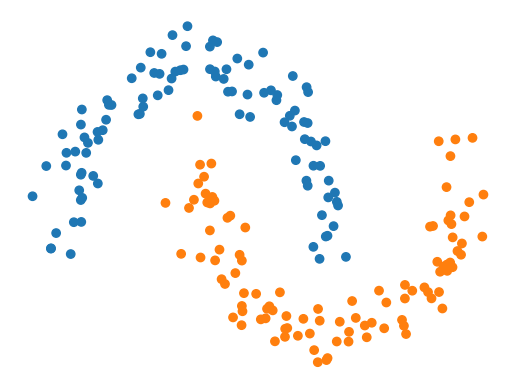

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

#### Q-model

In [12]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


In [16]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

### Creating a hybrid model

In [25]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

In [26]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [ ]:
X_tens = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X_tens, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

In [28]:

epochs = 6
for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    
    y_pred = model(X)
    predictions = torch.argmax(y_pred, axis=1).detach().numpy()
    correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
    accuracy = sum(correct) / len(correct)
    print(f"Accuracy over epoch {epoch + 1}: {accuracy * 100}%")

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.1601
Accuracy over epoch 0: 87.5%
Average loss over epoch 2: 0.1565
Accuracy over epoch 1: 86.5%
Average loss over epoch 3: 0.1543
Accuracy over epoch 2: 86.5%
Average loss over epoch 4: 0.1545
Accuracy over epoch 3: 87.0%
Average loss over epoch 5: 0.1468
Accuracy over epoch 4: 85.0%
Average loss over epoch 6: 0.1528
Accuracy over epoch 5: 86.5%
Accuracy: 86.5%


А также большое количество доступных темплейтов схем квантовых https://docs.pennylane.ai/en/stable/introduction/templates.html

<!-- И гибкая возможность создавать операторы https://docs.pennylane.ai/en/stable/introduction/operations.html и не только  -->

Вычисление геометрии молекул в qChem https://pennylane.ai/qml/demos/tutorial_mol_geo_opt.html

## GPU accelerated simulation.



### PennyLane-Lightning-GPU Plugin


The [PennyLane-Lightning-GPU](https://github.com/PennyLaneAI/pennylane-lightning-gpu) plugin extends the [Pennylane-Lightning ](https://github.com/PennyLaneAI/pennylane-lightning) state-vector simulator written in C++, and offloads to the [NVIDIA cuQuantum SDK ](https://developer.nvidia.com/cuquantum-sdk) for GPU accelerated circuit simulation.

Но до примерно 15 кубитов не дает преимущества. (https://quantumai.google/qsim/choose_hw)

(В стандартном симуляторе вроде на cpu все считается) [link](https://pennylane.ai/qml/demos/pytorch_noise.html)
When using a classical interface that supports GPUs, the QNode will automatically copy any tensor arguments to the CPU, before applying them on the specified quantum device. Once done, it will return a tensor containing the QNode result, and automatically copy it back to the GPU for any further classical processing.



### Supported operations:
```
BasisState
CNOT
CRot
CRX
CRY
CRZ
Hadamard
PauliX
PauliY
PauliZ
PhaseShift
ControlledPhaseShift
QubitStateVector
Rot
RX
RY
RZ
S
T  
```

Использует метод дифференцирования adjoint. [Туториал](https://pennylane.ai/qml/demos/tutorial_adjoint_diff.html) от pennyLane

$$\langle M \rangle = \langle b | k \rangle = \langle \Psi | M | \Psi \rangle$$

Раскладываем матожидание на скалярное произведение двух векторов

$$\langle b | = \langle \Psi| M = \langle 0 | U_0^{\dagger} \dots U_n^{\dagger} M$$
$$| k \rangle =  |\Psi \rangle = U_n U_{n-1} \dots U_0 |0\rangle$$

Можем менять место разбиения, перебрасывая матрицы поочереди из одного вектора в другой.
$$\langle b_i | = \langle 0 | U_1^{\dagger} \dots U_n^{\dagger} M U_n \dots U_{i+1}$$
$$|k_i \rangle = U_{i-1} \dots U_1 |0\rangle$$

$$\langle b_i | = \langle b_{i+1}| U_{i}$$
$$|k_{i} \rangle = U_{i+1}^{\dagger} |k_{i+1}\rangle$$

Для подсчета производной в нужное разбиение вставляется матричная производная по параметру.

$$\langle 0 | U_1^{\dagger} \dots U_i^{\dagger} \dots M \dots \frac{\text{d} U_i}{\text{d} \theta_i}  \dots U_1 |0\rangle$$
$$= \langle b_i | \frac{\text{d} U_i}{\text{d} \theta_i} |k_i \rangle$$


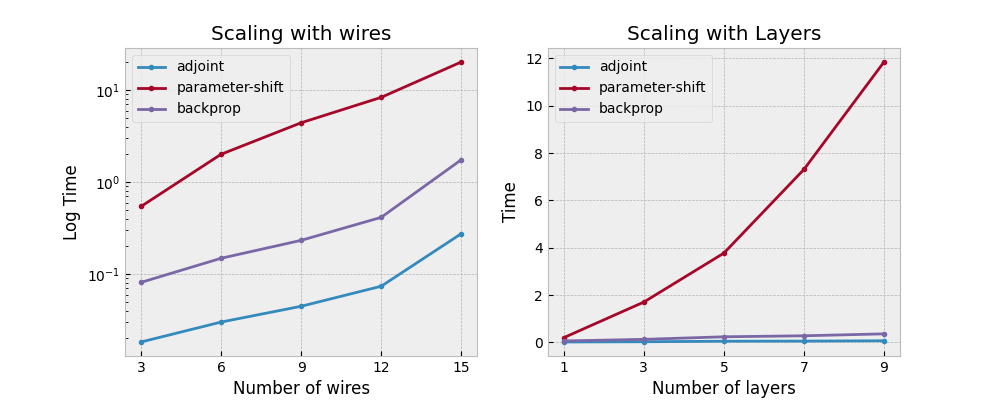

У tensorflow quantum есть вроде гайд по запуску cirq на GPU (https://quantumai.google/qsim/tutorials/gcp_gpu)

Но при этом и на stackoverflow вопрос про это есть без ответа https://stackoverflow.com/questions/73250190/does-tensorflow-quantum-support-gpu-and-if-so-how-do-i-make-it-use-mine

уже почти 2 года отрытый issue вообще не двигается https://github.com/tensorflow/quantum/issues/599

Более свежий issue у них на гитхабе с ссылкой на вопрос на stackoverflow тоже вроде говорит, что нет поддержки gpu https://github.com/tensorflow/quantum/issues/732

## Симуляция шума

Элементы создающие шум и моделирование матриц плотности в pennylane тоже есть. Прочего синтаксического сахара, как в Circ я не нашел.
https://pennylane.ai/qml/demos/tutorial_noisy_circuits.html

In [4]:
dev = qml.device('default.mixed', wires=2)

@qml.qnode(dev)
def bitflip_circuit(p):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.BitFlip(p, wires=0)
    qml.BitFlip(p, wires=1)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))


ps = [0.001, 0.01, 0.1, 0.2]
for p in ps:
    print(f"QNode output for bit flip probability {p} is {bitflip_circuit(p):.4f}")

QNode output for bit flip probability 0.001 is 0.9960
QNode output for bit flip probability 0.01 is 0.9604
QNode output for bit flip probability 0.1 is 0.6400
QNode output for bit flip probability 0.2 is 0.3600


## Сторонние симуляторы

Создавая device можно указать один из многочисленных поддерживаемых симуляторов(, или реальный квантовый компьютер).

```
dev = qml.device('cirq.simulator', wires=2)
```

Встроенные:

|Device|Description|
|-|-|
|default.qubit | A simple state-vector qubit simulator written in Python, with Autograd, JAX, TensorFlow, and Torch backends. <br /> A good choice for optimizations with a moderate number of qubits and parameters with exact expectation values. |
|default.mixed | A mixed-state qubit simulator written in Python, with Autograd, JAX, TensorFlow, and Torch backends.<br /> A good choice for simulating noisy circuits and quantum channels.|
|default.gaussian | A simple quantum photonic simulator written in Python. <br />A good choice for optimizing photonic systems.|
|||
|lightning.qubit |A fast state-vector qubit simulator written with a C++ backend. <br />  A good choice for optimizations with a moderate number of qubits and parameters, or when using stochastic expectation values.|
|lightning.gpu| A fast state-vector qubit simulator utilizing the NVIDIA cuQuantum SDK for GPU accelerated circuit simulation. <br />  A good choice for a large number of qubits and parameters, taking advantage of one or more GPUs for acceleration. |

А также есть плагины для доступа к сторонним симуляторам `Qiskit`, `Cirq`, `Microsoft QDK` и [прочие](https://pennylane.ai/plugins/)

Есть, что интересно, поддерижваемый сообществом плагин с высокопроизводительной mixed state simulation 

**PyQuest** \
PyQuest is a Python library that connects to the high-performance mixed state simulator QuEST.

Туториалы доступные:

- [link](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) классификация 2 классов iris датасета.
- [link](https://pennylane.ai/qml/demos/tutorial_kernels_module.html) очень игрушечная задача с kernel методом. И еще kernel method [link](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html)